# VarClump2D: Agglomeration test


In [10]:
%matplotlib inline

import os
import sys
import copy
import time
from array import array
import numpy as np
np.seterr(over='ignore')
import scipy as sp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from ipywidgets import interact, interactive, fixed, FloatSlider

# autoreload user modules functionality
%load_ext autoreload
%autoreload 2

# VarClump functions
sys.path.append('../lib/')
from utils import *
from graph import *
from points_generation import *
from initial_guess import *
from variational import *
from gmr import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading data 2D: Stacked on frequency

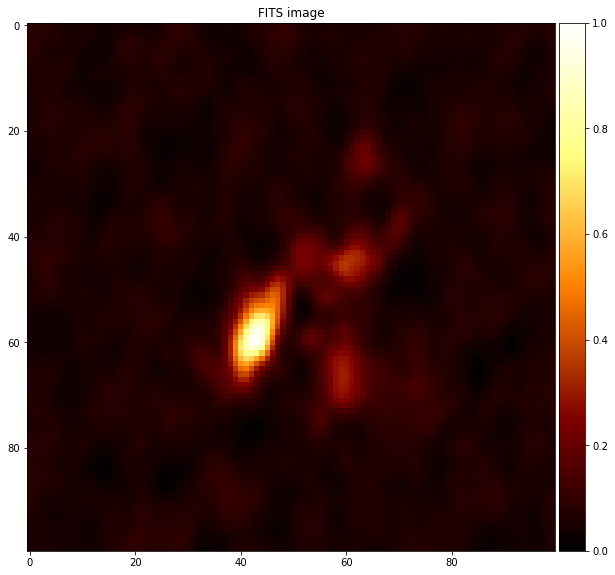

In [11]:
"""
Loading data
"""

fits_path = '../data/images/Orion.cont.image.fits'
x, y, data, dfunc = load_data(fits_path)
image_plot(data)

In [12]:
base_level = estimate_rms(data)
interact(thresholded_image_plot, data=fixed(data), level=FloatSlider(min=base_level,max=1.,step=0.01,value=base_level))

/Users/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.thresholded_image_plot>

## Euler-Lagrange Derivation

Given the following functional: 

$$J(u) = \int_{\Omega \subset \mathbb{R}^2} L(x, y, u, u_x, u_y) \ d\Omega  = \int_{\Omega \subset \mathbb{R}^2}(u(x,y)-f_0(x,y))^2 + \alpha \ \Psi_1(u(x,y)-f_0(x,y)) + \beta \ \Psi_2(\left|\nabla u(x,y)\right|^2) \ d\Omega $$

then when we try to minimize it, the corresponding Euler-Lagrange equation becomes:

$$
\frac{\partial L}{\partial u}-\frac{d}{dx}\frac{\partial L}{\partial u_x} - \frac{d}{dy}\frac{\partial L}{\partial u_y}= 0$$

$$
2(u-f) + \alpha \Psi_1'(u-f) -2\beta \Big( 2\Psi_2''(u_x^2+u_y^2) \left[(u_x u_{xx} + u_y u_{yx})u_x + (u_x u_{xy} + u_y u_{yy})u_y \right] + \Psi_2'(u_x^2 + u_y^2) \left[u_{xx}+u_{yy} \right] \Big) = 0
$$

whit boundary condition $u(\partial \Omega) = f(\partial \Omega)$. The proposed solution has the form of a linear combination of Gaussian functions:

$$u(x,y) = \sum_{i=1}^N c_i \ \phi(x, y;\ x_i,y_i, \sigma_i) = \sum_{i=1}^N c_i \ e^{-\frac{(x-x_i)^2 + (y-y_i)^2}{2 \sigma_i^2}}$$

# Experiments: With  `base_level=RMS`
The following instances are tests with different settings combinations for: square_c

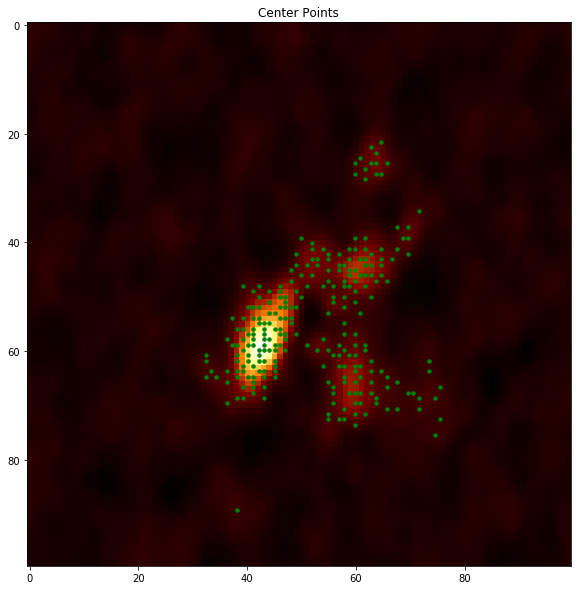

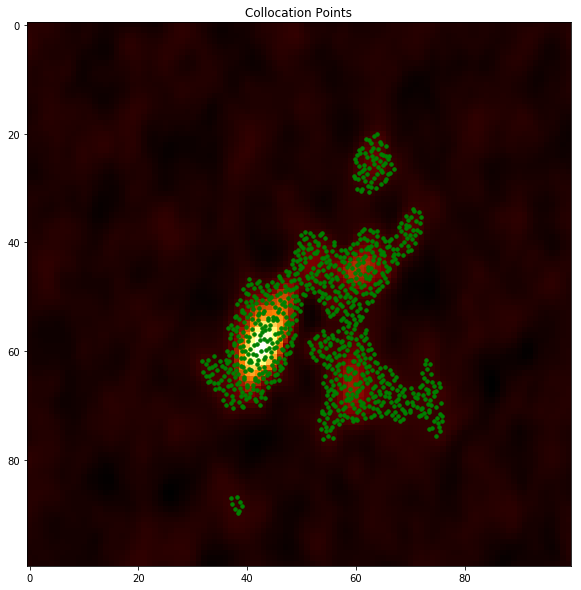

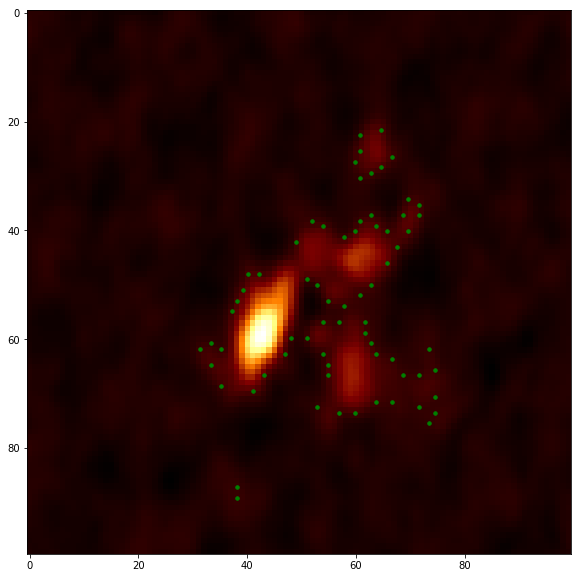

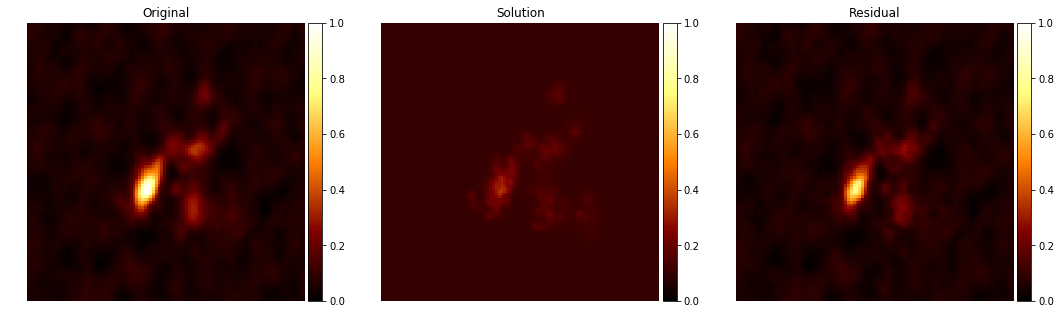

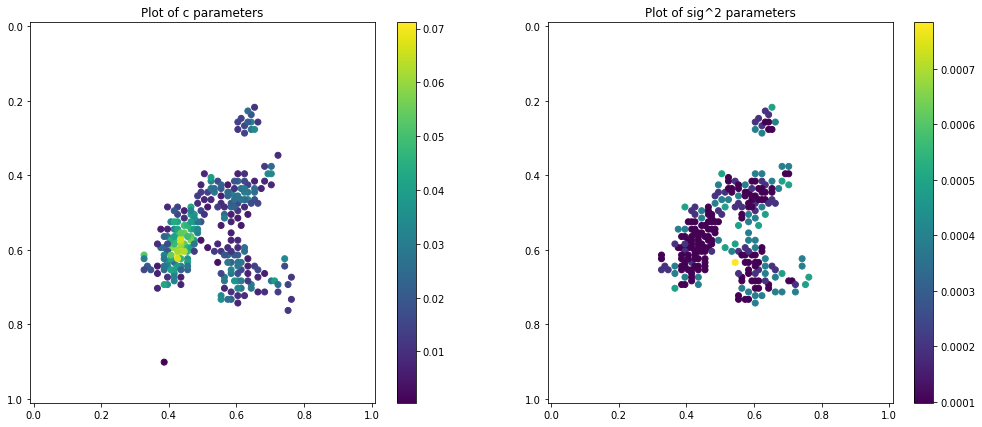

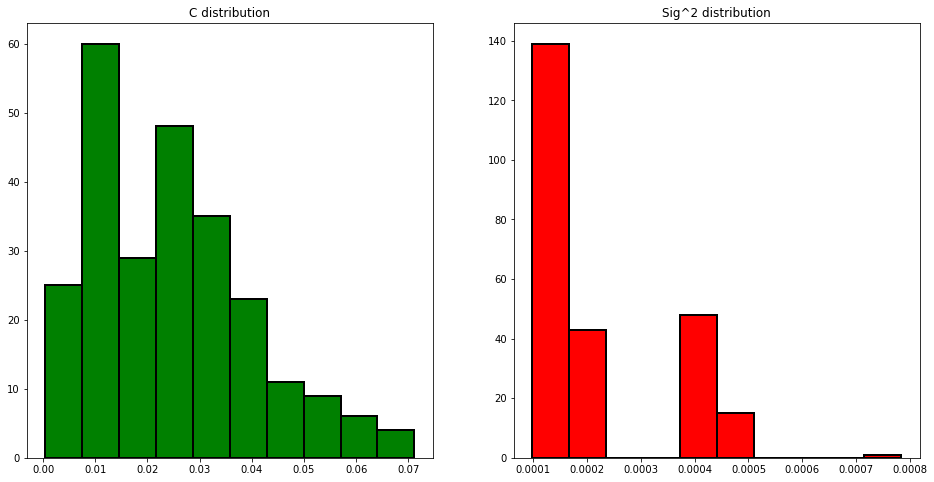

In [13]:
##########################################
# Approach 1
##########################################
Nc = 250
Nb = int(0.2* np.sum(boundary_map(data, base_level))) #20% of boundary pixels
Ne = 4*Nc - Nb

center_points = random_centers_generation(data, Nc, base_level=base_level, power=3.)
collocation_points = qrandom_centers_generation(dfunc, Ne, base_level, ndim=2)
boundary_points = boundary_points_generation(data, base_level, Nb)


# right format
xc = center_points[:,0]
yc = center_points[:,1]
xe = collocation_points[:,0]
ye = collocation_points[:,1]
xb = boundary_points[:,0]
yb = boundary_points[:,1]


# visualizing the choosen points
points_plot(data, center_points=center_points, title="Center Points")
points_plot(data, center_points=collocation_points, title="Collocation Points")
points_plot(data, boundary_points=boundary_points, title="Boundary Points")


####################################
# Initial parameters estimation
####################################
minsig = ( 0.5*(1./data.shape[0] + 1./data.shape[1]) ) / 6.
maxsig = 30*minsig
c0, sig0 = estimate_initial_guess(center_points, dfunc, minsig=minsig, maxsig=maxsig, method='min_dist')

solution_plot(dfunc, c0, sig0, xc, yc, dims=data.shape, base_level=base_level)
params_plot(c0, sig0, xc, yc)
params_distribution_plot(c0, sig0)


elm01 = ELModel(data, dfunc, data.shape, xe, ye, xc, yc, xb, yb, c0, sig0, a=1., lamb1=1., d1psi1=d1psi, 
                d1psi2=d1psi, d2psi2=d2psi, base_level=base_level, pix_freedom=1.)


 
##########################################################################################
FINAL RESULTS:
##########################################################################################

Solver Output:
success: False
status: 5
message: Number of calls to function has reached maxfev = 100100.
nfev: 100109

Residual stats:
Residual RMS: 0.0041289728890513905
Residual Variance: 1.6765507389887453e-05
Residual Entropy: 7.140436330849772
Added Flux: 1.1781417577698183
Total elapsed time: 264.8794631958008 [s]

Coverage of solution:
Hausdorff distance between collocation and center points: 0.03368965969923373
Mean min distance between collocation and center points: 0.009546047123767873

Homogeneity of solution:
Mean min distance in the (standarized) parameters space: 0.07440171913177117
Max min distance in the (standarized) parameters space: 0.5747975762692826


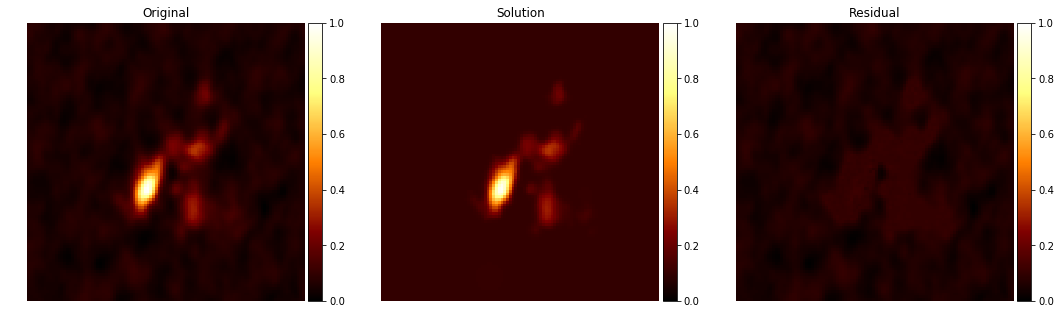

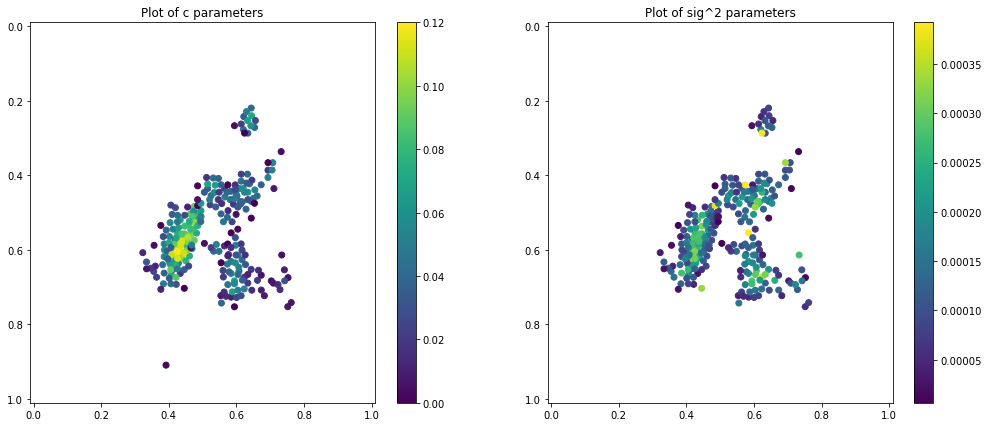

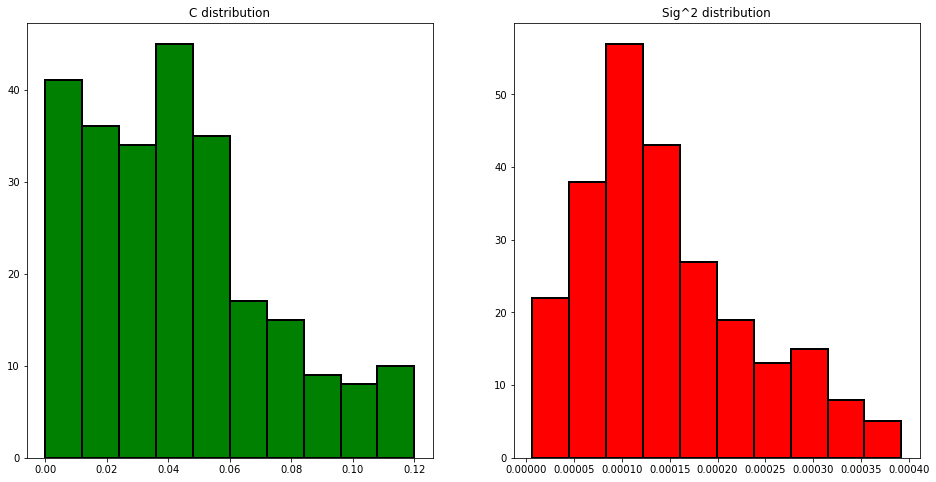

In [14]:
nfev = 100*(len(elm01.get_params())+1)
elm_solver(elm01, method='standard', max_nfev=nfev)

In [16]:
xc, yc, c, sig = elm01.get_params_mapped()
w = elm01.get_w()
mu = np.vstack([xc, yc]).T

### Test with `KL-divergence`

In [17]:
components_dict01, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='KL', verbose=True)

Merged components 160 and 164 with 1.0556684195938715e-16 KL dist and 8.870375440171509e-32 ISD dist
Merged components 205 and 248 with 7.157801176120953e-16 KL dist and 2.4789392822511911e-29 ISD dist
Merged components 201 and 247 with 5.443573436691706e-15 KL dist and 2.186187230561858e-27 ISD dist
Merged components 207 and 246 with 4.078227884505429e-14 KL dist and -1.4823076576950256e-21 ISD dist
Merged components 210 and 214 with 1.1140598931782167e-13 KL dist and -7.199780051661553e-21 ISD dist
Merged components 16 and 202 with 7.891748745128373e-10 KL dist and 4.389770483760277e-16 ISD dist
Merged components 33 and 158 with 1.0833212070458255e-09 KL dist and 5.298250377381956e-16 ISD dist
Merged components 25 and 204 with 1.4884181686230251e-09 KL dist and 1.8002562975235042e-16 ISD dist
Merged components 110 and 183 with 3.814519346548827e-09 KL dist and 4.645467495921485e-16 ISD dist
Merged components 98 and 137 with 2.2812824778825793e-07 KL dist and 1.828614936478315e-11 ISD

In [19]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict01), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

/Users/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.components_plot>

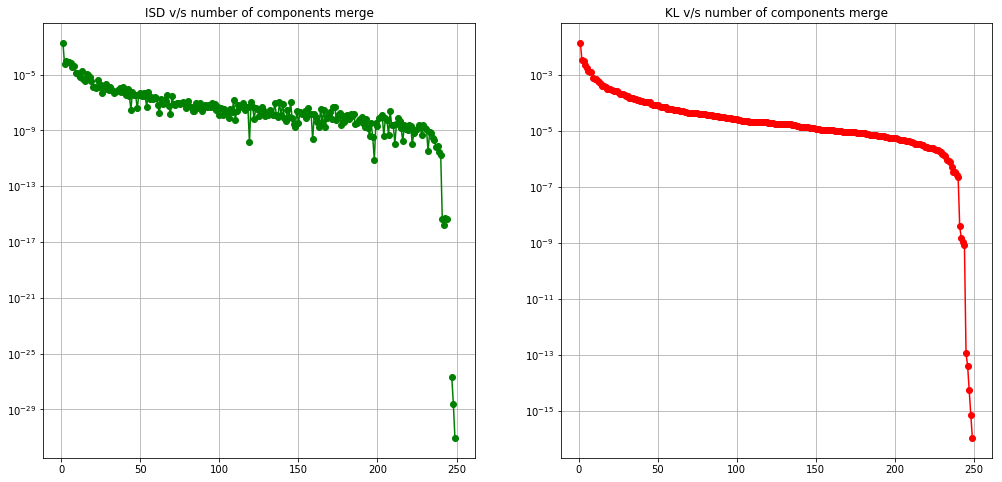

In [37]:
ncomp = list(range(len(isd_hist),0,-1))
plt.figure(figsize=(17,8))
plt.subplot(1,2,1)
plt.semilogy(ncomp, isd_hist, "go-")
plt.title("ISD v/s number of components merge")
plt.grid()
plt.subplot(1,2,2)
plt.semilogy(ncomp, kl_hist, "ro-")
plt.title("KL v/s number of components merge")
plt.grid()
plt.show()

### Test with `ISD`

In [41]:
components_dict02, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='ISD', verbose=True)

Merged components 1 and 219 with -2.371692252312041e-20 ISD dist
Merged components 159 and 248 with -2.710505431213761e-20 ISD dist
Merged components 55 and 201 with -2.202285662861181e-20 ISD dist
Merged components 203 and 245 with -2.0328790734103208e-20 ISD dist
Merged components 115 and 161 with -1.9481757786848908e-20 ISD dist
Merged components 25 and 206 with 1.8002562975235042e-16 ISD dist
Merged components 155 and 198 with 1.9394314932454542e-16 ISD dist
Merged components 110 and 182 with 4.645467495921485e-16 ISD dist
Merged components 32 and 240 with 7.159995782337789e-14 ISD dist
Merged components 84 and 195 with 6.450809908232379e-12 ISD dist
Merged components 12 and 138 with 7.89530467049717e-12 ISD dist
Merged components 213 and 227 with 1.064025696467997e-11 ISD dist
Merged components 133 and 233 with 1.767091442112954e-11 ISD dist
Merged components 22 and 182 with 3.3328211060053064e-11 ISD dist
Merged components 101 and 141 with 5.219774897256288e-11 ISD dist
Merged co

In [47]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict02), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

/Users/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.components_plot>

In [48]:
components_dict03, isd_hist, kl_hist = gaussian_reduction(w, mu, sig, n_comp=1, metric='ISD_', verbose=True)

Merged components 116 and 164 with -7.73070496506989e-12 ISD dist
Merged components 8 and 159 with -6.59383658785373e-12 ISD dist
Merged components 42 and 199 with -4.320099833421409e-12 ISD dist
Merged components 92 and 201 with -4.320099833421409e-12 ISD dist
Merged components 195 and 211 with -2.0463630789890885e-12 ISD dist
Merged components 110 and 183 with 2.516250674489129e-08 ISD dist
Merged components 25 and 202 with 6.079710601625266e-08 ISD dist
Merged components 32 and 153 with 2.1832943275512662e-07 ISD dist
Merged components 15 and 192 with 3.6533549518935615e-07 ISD dist
Merged components 12 and 137 with 0.00035309987396203724 ISD dist
Merged components 1 and 89 with 0.000610316306307368 ISD dist
Merged components 130 and 233 with 0.0009564100779755336 ISD dist
Merged components 128 and 236 with 0.0011440539599902877 ISD dist
Merged components 17 and 49 with 0.0034889564732623057 ISD dist
Merged components 19 and 176 with 0.003658727306003584 ISD dist
Merged components 7

In [49]:
interact(components_plot, elm=fixed(elm01), data=fixed(data), components_dict=fixed(components_dict03), n_comp=(1,20), dims=fixed(data.shape), resolution=fixed(1), n_levels=fixed(5))

/Users/mavillan/anaconda3/lib/python3.6/site-packages/traitlets/traitlets.py:567: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  silent = bool(old_value == new_value)


<function graph.components_plot>